# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader


# Download Dataset

In [2]:
file={"username":"mojtabanafez","key":"7c0ebd541704e0cb4357c05f78ed5fa2"}
import json
with open('kaggle.json', 'w') as fp:
    json.dump(file, fp)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

 99% 1.81G/1.83G [00:16<00:00, 121MB/s]
100% 1.83G/1.83G [00:16<00:00, 122MB/s]


In [4]:
# !gdown --id 1-8UrAsreTpYezl2z58xdg8v6ab2BbYmu

In [5]:
!unzip -q /content/stanford-car-dataset-by-classes-folder.zip

# Create Generator

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

TRAIN_DATA_PATH = "./car_data/car_data/train"
TEST_DATA_PATH = "./car_data/car_data/test"

TRANSFORM_IMG =  transforms.Compose(
    [
      transforms.ToTensor(), 
      transforms.Resize(size=(224,224)),
     ])
BATCH_SIZE=32
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

train_data_ini = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader_ini = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True,  num_workers=2)

test_data_ini = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader_ini  = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=2) 


In [7]:
len(train_data_loader), len(test_data_loader)

(255, 252)

In [10]:
dl=iter(train_data_loader)
x, y= next(dl)
x.shape, y.shape, torch.mean(x), torch.min(x), torch.max(x)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 tensor(0.4573),
 tensor(0.),
 tensor(1.))

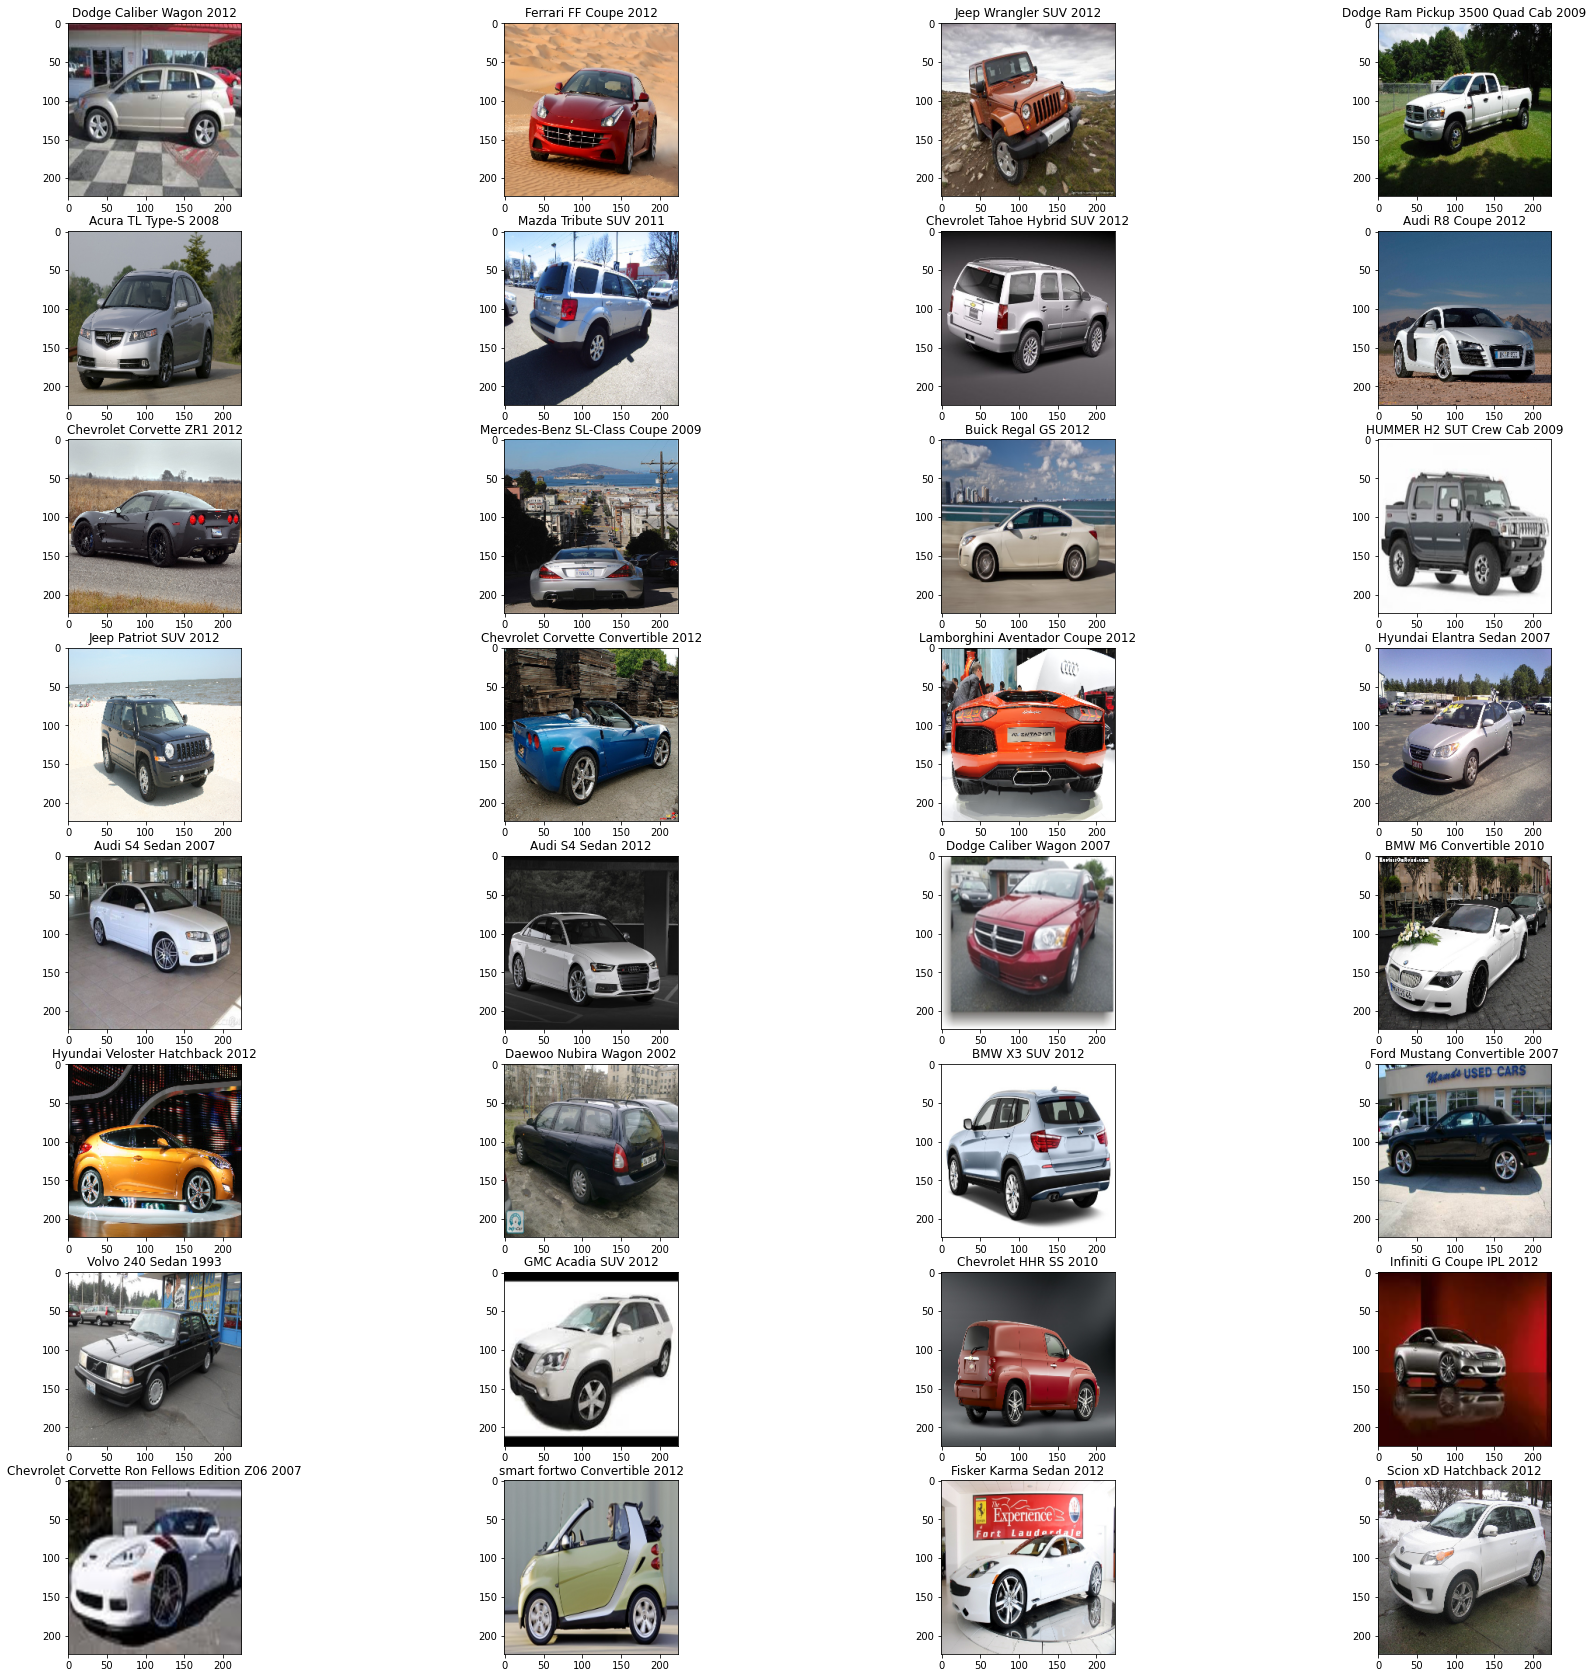

In [13]:
import numpy as np

classes = list(train_data.class_to_idx)


test_loader=iter(test_data_loader)
image, labels = test_loader.next()
image=np.array(image)
nrows=8
ncols=4
plt.figure (figsize = (30, 30))
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 1, 2))
for i in range(image.shape[0]):
    sp = plt.subplot(nrows, ncols, i+1)
    plt.imshow(image[i])
    plt.title(classes[int(labels[i])])
plt.show()
# print(image.shape, np.mean(image), np.max(image), np.min(image))

In [11]:
dataloaders={
    'train':train_data_loader,
    'val': test_data_loader
}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)


def load_checkpoint (checkpoint, model):
    """ loading model's weights """
    print ('=> loading checkpoint')
    model.load_state_dict (checkpoint ['state_dict'])


def train_model(model, criterion, optimizer, scheduler, num_epochs=10, name="just_use_net"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                current_corrects += torch.sum(preds == labels.data)            

            # saving weights
            if epoch % 3 == 0:
              checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
              save_checkpoint(checkpoint, f'/content/checkpoint_{name}__{epoch}.pt')
            
            epoch_loss = current_loss / dataset_sizes[phase]
            # epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_acc = 100/32*current_corrects/dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
dataset_sizes

{'train': 255, 'val': 252}

In [12]:
class ResnetModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(ResnetModel, self).__init__()

        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

res_mod = models.resnet50(pretrained=False)
model = ResnetModel(res_mod, num_classes=len(classes))
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

NameError: ignored

In [ ]:
model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


KeyboardInterrupt: ignored

# Feature extracting 

In [ ]:
resnet_pretrained = models.resnet50(pretrained=True)
#freeze part model and train the rest
for param in resnet_pretrained.parameters():
    param.requires_grad = False


resnet_pretrained.fc = nn.Linear(resnet_pretrained.fc.in_features, len(classes))


pytorch_total_params = sum(p.numel() for p in resnet_pretrained.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in resnet_pretrained.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

pytorch_total_params=  23909636
pytorch_total_trainable_params=  401604


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_pretrained = resnet_pretrained.to(device)
criterion = nn.CrossEntropyLoss() 

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(resnet_pretrained.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
base_model = train_model(resnet_pretrained, criterion, optimizer_ft, exp_lr_scheduler,name= "Feature_extracting", num_epochs=10)


Epoch 0/9
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


=> saving checkpoint
train Loss: 154.9780 Acc: 7.9044
Iterating through data...
=> saving checkpoint
val Loss: 127.2014 Acc: 16.4062

Epoch 1/9
----------
Iterating through data...
train Loss: 104.7833 Acc: 27.9412
Iterating through data...
val Loss: 107.7103 Acc: 25.2728

Epoch 2/9
----------
Iterating through data...
train Loss: 82.6612 Acc: 41.0539
Iterating through data...
val Loss: 100.9430 Acc: 28.4226

Epoch 3/9
----------
Iterating through data...
=> saving checkpoint
train Loss: 69.1861 Acc: 49.5956
Iterating through data...
=> saving checkpoint
val Loss: 96.8165 Acc: 29.6875

Epoch 4/9
----------
Iterating through data...
train Loss: 59.1075 Acc: 55.7721
Iterating through data...
val Loss: 92.8205 Acc: 32.2421

Epoch 5/9
----------
Iterating through data...
train Loss: 52.3176 Acc: 60.1838
Iterating through data...
val Loss: 88.9512 Acc: 34.6230

Epoch 6/9
----------
Iterating through data...
=> saving checkpoint
train Loss: 36.2229 Acc: 78.1495
Iterating through data...
=> s

# Feature extracting with svm

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
# function for Feature Extractor + SVM
# a = np.array(range(196))

def feature_extraction(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature = []
    target = []
    step = False

    print('================================')
    running_corrects = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # feature extraction
        outputs = model(inputs)
        classifier_input = outputs.to('cpu').detach().numpy()
        classifier_target = labels.to('cpu').detach().numpy()
        feature.append(classifier_input)
        target.append(classifier_target)

    print()
    return feature, target    

In [37]:
from sklearn.svm import SVC

resnet_model =  models.resnet50(pretrained=True)
resnet_model.to(device)
for param in resnet_model.parameters():
  param.require_grad = False
svclassifier = SVC(kernel = 'linear',gamma = 'scale', shrinking = False)

In [38]:
features, targets = feature_extraction(resnet_model,train_data_loader_ini)

In [47]:
f = np.array(features) 
t = np.array(targets) 

In [76]:
f.shape

(8144, 1000)

In [55]:
nsamples, nx, ny = f.shape
f = f.reshape((nsamples,nx*ny))

In [56]:
svclassifier.fit(f, t)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', shrinking=False)

In [57]:
f.shape

(8144, 1000)

In [74]:
train_corrects = 0
preds = svclassifier.predict(f)
for i in range(preds.shape[0]):
  if preds[i]==t[i]:
    train_corrects+=1
acc = train_corrects / f.shape[0]                                  
print('{} Acc: {:.4f}'.format('train', acc))

train Acc: 0.9982


In [82]:
tfeatures, ttargets = feature_extraction(resnet_model,test_data_loader_ini)

In [83]:
tf = np.array(tfeatures) 
tt = np.array(ttargets) 

In [84]:
nsamples, nx, ny = tf.shape
tf = tf.reshape((nsamples,nx*ny))

In [85]:
tf.shape

(8041, 1000)

In [87]:
tt.shape


(8041, 1)

In [88]:
tpreds = svclassifier.predict(tf)

In [99]:
tpreds.shape

(8041,)

In [102]:
test_corrects = 0
for i in range(tpreds.shape[0]):
  if tpreds[i]==tt[i]:
    test_corrects+=1
acc = test_corrects / tf.shape[0]                                  
print('{} acc: {:.4f}'.format('test', acc))

test acc: 0.1135


# Fine tune

In [14]:
resnet_pretrained = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
for name, child in resnet_pretrained.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [16]:
for name, child in resnet_pretrained.named_children():
    if name == "layer4":
      for param in child.parameters():
        print(param)

Parameter containing:
tensor([[[[-0.0114]],

         [[ 0.0056]],

         [[ 0.0091]],

         ...,

         [[-0.0149]],

         [[-0.0054]],

         [[ 0.0212]]],


        [[[ 0.0365]],

         [[ 0.0337]],

         [[ 0.0138]],

         ...,

         [[-0.0107]],

         [[-0.0036]],

         [[ 0.0142]]],


        [[[-0.0061]],

         [[ 0.0107]],

         [[-0.0098]],

         ...,

         [[-0.0193]],

         [[ 0.0340]],

         [[-0.0065]]],


        ...,


        [[[-0.0116]],

         [[-0.0074]],

         [[ 0.0434]],

         ...,

         [[-0.0067]],

         [[ 0.0160]],

         [[ 0.0148]]],


        [[[-0.0101]],

         [[-0.0027]],

         [[ 0.0338]],

         ...,

         [[-0.0121]],

         [[ 0.0240]],

         [[-0.0097]]],


        [[[ 0.0222]],

         [[ 0.0341]],

         [[-0.0104]],

         ...,

         [[-0.0272]],

         [[-0.0226]],

         [[-0.0282]]]], requires_grad=True)
Parameter cont

In [17]:
def unfreeze(child,flag=True):
  for param in child.parameters():
      param.requires_grad = flag


In [18]:

for name, child in resnet_pretrained.named_children():
    if name in ['layer2','fc']:
      print(f"{name} - unfreezed")
      unfreeze(child)
    elif name in ['layer4'] :
      unfreeze(child[0],False)
      unfreeze(child[1],False)
      unfreeze(child[2])
    else:
      unfreeze(child,False)

pytorch_total_params = sum(p.numel() for p in resnet_pretrained.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in resnet_pretrained.parameters() if p.requires_grad)
print('pytorch_total_params= ', pytorch_total_params )
print('pytorch_total_trainable_params= ', pytorch_total_trainable_params)

layer2 - unfreezed
fc - unfreezed
pytorch_total_params=  25557032
pytorch_total_trainable_params=  7731176


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

res_pre_mod = resnet_pretrained.to(device)

criterion = nn.CrossEntropyLoss() 

optimizer = optim.Adam(filter(lambda p: p.requires_grad, res_pre_mod.parameters()), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

res_pre_mod = train_model(res_pre_mod, criterion, optimizer, exp_lr_scheduler , name="fine-tuning-layer4-fc-model", num_epochs=15)

Epoch 0/14
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


=> saving checkpoint
train Loss: 135.7388 Acc: 14.3995
Iterating through data...
=> saving checkpoint
val Loss: 95.8366 Acc: 25.3720

Epoch 1/14
----------
Iterating through data...
train Loss: 66.7427 Acc: 43.7745
Iterating through data...
val Loss: 72.8217 Acc: 41.3070

Epoch 2/14
----------
Iterating through data...
train Loss: 40.0761 Acc: 63.8480
Iterating through data...
val Loss: 55.9408 Acc: 53.0258

Epoch 3/14
----------
Iterating through data...
=> saving checkpoint
train Loss: 22.6065 Acc: 79.0196
Iterating through data...
=> saving checkpoint
val Loss: 54.0852 Acc: 55.7788

Epoch 4/14
----------
Iterating through data...
train Loss: 13.9793 Acc: 86.9730
Iterating through data...
val Loss: 52.8696 Acc: 58.0977

Epoch 5/14
----------
Iterating through data...
train Loss: 10.4022 Acc: 90.2206
Iterating through data...
val Loss: 53.3561 Acc: 58.9162

Epoch 6/14
----------
Iterating through data...
=> saving checkpoint
train Loss: 3.6225 Acc: 97.1324
Iterating through data...
=>

train Acc: 0.9982
